### Introduction

The goal of this notebook is to build from scratch a neural network for an image classficiation task.

This is to have a good grasp of deep learning concepts ..

## Plan

**1-** Prepare the dataset

**2-** Implementing the forward pass

**3-** Implementing the backwad pass

**4-** Evaluating the performance of the nn

**5-** Experiments with the nn parametres and how they affect the performances 

Some questions that we want to answer are : 

* Can we find some correlation between the variance in the dataset and the size of the neural network? 
* Is the bias part of the neurons important in the task?
* Does the activation function affects the value to be choosen for the learning rate

## 1-  Loading the dataset

In [25]:
import tensorflow as tf

# Load the MNIST dataset                                
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Shuffle the training data
indices = tf.range(start=0, limit=tf.shape(x_train)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

x_train = tf.gather(x_train, shuffled_indices)
y_train = tf.gather(y_train, shuffled_indices)

# Convert tensors back to numpy arrays
x_train = x_train.numpy()
y_train = y_train.numpy()

# Display the shape of the loaded data
print("Training data shape:", x_train.shape)  # (60000, 28, 28)
print("Training labels shape:", y_train.shape)  # (60000,)
print("Test data shape:", x_test.shape)  # (10000, 28, 28)
print("Test labels shape:", y_test.shape)  # (10000,)

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


##  2-  Visualizing the dataset

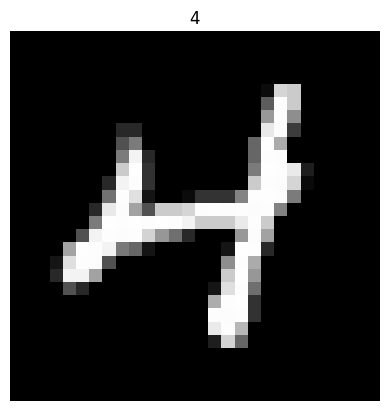

In [26]:
import matplotlib.pyplot as plt
import numpy as np

random_idx = np.random.randint(1000)

image = x_train[random_idx]
label = y_train[random_idx]


def visualize_image(image, label):
    plt.imshow(image, cmap='gray')  # Display the image
    plt.axis('off')  # Turn off the axes
    plt.title(label)
    plt.show()  # Show the image
    
visualize_image(image, label)

==> Each image is a **28*28** pixels, which gives a list of **784** elements

## 3- Implementing the forward pass

Our neural network, would be such that there is only one hidden layer with **300** neurons, and the output layer with **10**neurons

For now, the activations functions would be all linear, and in to generate the output we take the argmax.

Our loss function will be the Mean Squared Error, aka **MSE**

In [27]:
input_layer = image.flatten()

In [28]:
## Initializing the weights linking the input layer with the hidden layer

size_input_layer = len(input_layer) #784
size_hidden_layer = 300
size_output_layer = 10
print(len(input_layer))

def init_weights():
    weight_input_hidden = np.random.random((size_input_layer, size_hidden_layer))
    weight_hidden_output = np.random.random((size_hidden_layer, size_output_layer))
    
    return weight_input_hidden, weight_hidden_output

weight_input_hidden, weight_hidden_output = init_weights()
weights = weight_input_hidden, weight_hidden_output

784


In [29]:
# Hidden layer result
hidden_representation = np.dot(input_layer, weight_input_hidden)

# Min max normalization
mi = hidden_representation.min()
ma = hidden_representation.max()

# min max normalization
norm_hidden_representation = (hidden_representation - mi)/(ma-mi)

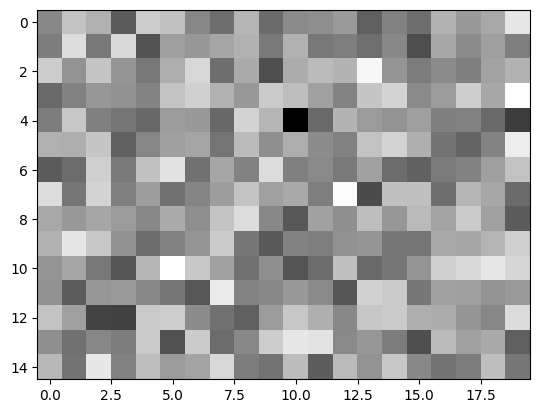

In [30]:
plt.imshow(norm_hidden_representation.reshape(15,20), cmap='gray')  # Display the image

In [31]:
## hidden output result 

ouput_result = np.dot(norm_hidden_representation, weight_hidden_output)
ouput_result.shape

(10,)

In [32]:
# Result of the forward pass
ouput_result.argmax()

3

In [33]:
# Defining the function that takes as an input the input layer(vector) and parameters and returns the predicted written number
def predict_number(input_layer, weights):
    size_input_layer = len(input_layer) #784
    size_hidden_layer = 300
    size_output_layer = 10
    
    weights = weight_input_hidden, weight_hidden_output

    hidden_representation = np.dot(input_layer, weight_input_hidden)
    mi = hidden_representation.min()
    ma = hidden_representation.max()

    # min max normalization
    norm_hidden_representation = (hidden_representation - mi)/(ma-mi)

    ouput_result = np.dot(norm_hidden_representation, weight_hidden_output)
    # Result of the forward pass
    result = ouput_result.argmax()
    return result


In [34]:
# Defining the function that takes as an input the input layer(vector) and parameters and returns the hidden representation and the output result
def forward_pass(input_layer, weights):
    
    weight_input_hidden, weight_hidden_output = weights
    
    hidden_representation = np.dot(input_layer, weight_input_hidden)
    
    mean = np.mean(hidden_representation)
    variance = np.var(hidden_representation)
    epsilon = 10 **(-5)
    scaled_hidden_representation = (hidden_representation - mean)/np.sqrt(variance + epsilon)

    output_result = np.dot(scaled_hidden_representation, weight_hidden_output)
    
    return scaled_hidden_representation, output_result

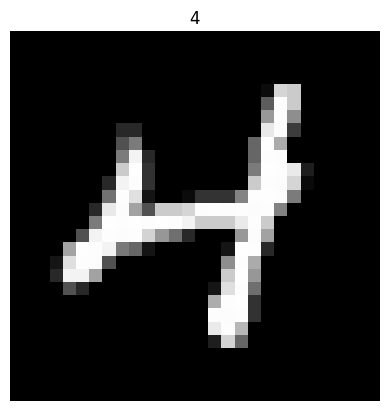

(300,)

In [35]:
#Test
visualize_image(image, label)
forward_pass(input_layer, weights)[0].shape

## 4- Implementing the backward pass:

This section would modify the *input_hidden_weights* and *hidden_output_weights* in order to make better predictions.

The weights modifications would be based on the backpropagation algorithms

In [36]:
def MSE(predicted, desired):
    # This function takes as input numpy arrays and not lists
    diff = 1/2 * ((predicted - desired)**2).sum()
    return diff

In [37]:
def full_backward_pass(weights, image, label, lr = 0.01, lamda = 0.01):
    # We only modify the weights between the last and the penultimate layer
    # weights is a tuple of matrices : weight_input_hidden & weight_hidden_output

    size_hidden_layer = 300
    size_output_layer = 10

    # one hot encoding the label
    desired = np.zeros(size_output_layer)
    desired[int(label)] = 1

    weight_input_hidden, weight_hidden_output = weights
    new_weight_input_hidden, new_weight_hidden_output = weight_input_hidden.copy(), weight_hidden_output.copy()

    input_layer = image.flatten() # flattening the image

    hidden_representation, output_result = forward_pass(input_layer, (weight_input_hidden, weight_hidden_output)) # forward pass

    output_result =  tf.nn.softmax(output_result) # softmax operation

    delta_matrix = np.zeros((size_hidden_layer, size_output_layer))

    # gradient descent iteration # backward pass for the second layer
    for k in range(size_output_layer):
        for j in range(size_hidden_layer):
            delta = (output_result[k] - desired[k]) * hidden_representation[j] * (1 - output_result[k]) * output_result[k]
            new_weight_hidden_output[j][k] = (1-lamda) * new_weight_hidden_output[j][k] - lr*delta

            delta_matrix[j][k] = delta

    for j in range(size_hidden_layer):
        for i in range(size_input_layer):
            delta = np.sum(new_weight_hidden_output[j]* (delta_matrix[j]) * input_layer[i] / hidden_representation[j])
            new_weight_input_hidden[i][j] = (1-lamda) * new_weight_input_hidden[i][j] - lr*delta


    return new_weight_input_hidden, new_weight_hidden_output

In [38]:
# testing the backward pass 

# preparing the args
random_idx += 1 

image = x_train[random_idx]; input_layer = image.flatten()
label = y_train[random_idx]

# one hot encoding
desired = np.zeros(size_output_layer)
desired[int(label)] = 1

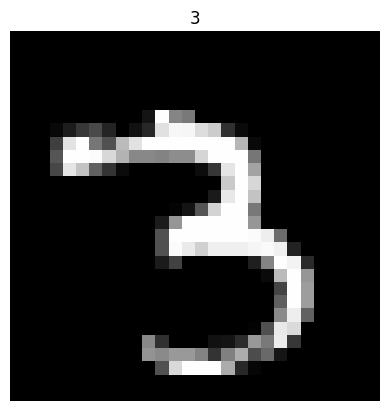

In [39]:
visualize_image(image, label)

In [40]:
# skip if you don't want to perform the backward pass
new_weight_input_hidden, new_weight_hidden_output = full_backward_pass(weights, image, label)

In [41]:
_, new_output = forward_pass(input_layer, (new_weight_input_hidden, new_weight_hidden_output))
norm_new_output = np.array(tf.nn.softmax(new_output)) # transforming the logits to probs
MSE(norm_new_output, desired)

0.6775347765695089

In [42]:
_, old_output = forward_pass(input_layer, (weight_input_hidden, weight_hidden_output))
norm_old_output = np.array(tf.nn.softmax(old_output))
MSE(norm_old_output, desired)

0.9714899373467004

In [43]:
new_output

array([  0.75235675,  -2.73837903, -38.55289994,  -1.07306186,
        -3.72286314,  -5.79217359,  -6.85918446,  -7.1939956 ,
        -2.3278849 ,  -2.06657197])

## 5 - Training and Validation loop:

In [44]:
from tqdm import tqdm

def train(weights, train_data, val_data=None):
    weight_input_hidden, weight_hidden_output = weights
    images, labels = train_data
    
    # List to store weights periodically
    saved_weights = []

    for idx, (image, label) in tqdm(enumerate(zip(images, labels))):
        new_weight_input_hidden, new_weight_hidden_output = full_backward_pass(weights, image, label)
        weights = new_weight_input_hidden, new_weight_hidden_output
        
        # Save weights every N iterations (e.g., every 10 images)
        if idx % 10 == 0:
            saved_weights.append(new_weight_input_hidden.copy())  
        
        if val_data and (idx % 3 == 0) and (idx != 0):
            metric_value = validate(weights, val_data)
            print(f"Metric value: {idx}th image (number: {label}): {metric_value}")

    return weights, saved_weights


In [45]:
def validate(weights, val_data):
    weight_input_hidden, weight_hidden_output = weights
    images, labels = val_data
    
    predicted_labels = []
    for image in images:
        input_layer = image.flatten()
        _, logits = forward_pass(input_layer, weights)
        predicted_label = np.argmax(logits)
        predicted_labels.append(predicted_label)
        
    return sum(predicted_labels == labels)/labels.shape[0]

In [51]:
# Preparing data
train_size = 360
val_size = 1000

train_data = x_train[350 :350 +train_size], y_train[350: 350 + train_size]
val_data = x_test[:val_size], y_test[:val_size]
weights = init_weights()

In [52]:
weights, saved_weights = train(weights, train_data, val_data)

4it [00:28,  6.82s/it]

Metric value: 3th image (number: 7): 0.087


7it [00:54,  8.83s/it]

Metric value: 6th image (number: 9): 0.094


10it [01:14,  7.39s/it]

Metric value: 9th image (number: 2): 0.094


13it [01:35,  6.96s/it]

Metric value: 12th image (number: 0): 0.094


16it [01:57,  7.32s/it]

Metric value: 15th image (number: 2): 0.094


19it [02:18,  7.04s/it]

Metric value: 18th image (number: 6): 0.094


21it [02:32,  7.23s/it]

In [48]:
validate(weights, val_data)

0.094

In [49]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_and_save_weights(saved_weights, image_shape, save_path="./"):
    for idx, weight_input_hidden in enumerate(saved_weights):
        plt.figure(figsize=(10, 6))
        num_filters = weight_input_hidden.shape[1]

        for i in range(num_filters):
            plt.subplot(num_filters // 10 + 1, 10, i + 1)  # Display 10 filters per row
            filter_img = weight_input_hidden[:, i].reshape(image_shape)
            plt.imshow(filter_img, cmap='gray')
            plt.axis('off')
        
        # Save the current figure as an image
        plt.savefig(f"{save_path}/weights_{idx}.png")
        plt.close()


# Assuming the images are 28x28 (like in MNIST)
image_shape = (28, 28)
save_path = "./"
visualize_and_save_weights(saved_weights, image_shape, save_path="./")


In [50]:
import plotly.express as px

fig = px.histogram(train_data[1], nbins=10, title='Training data distribution')
fig.update_xaxes(tickvals=np.arange(0, 10))
fig.show()

ModuleNotFoundError: No module named 'plotly'

## 6- Inference:

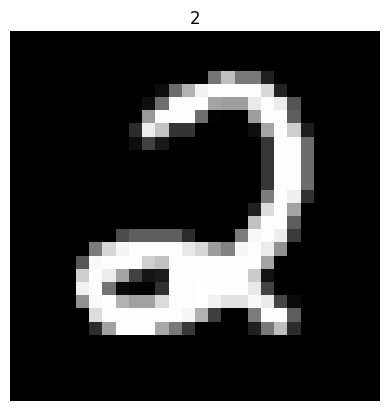

In [ ]:
random_idx = np.random.randint(1000)

image = x_train[random_idx]
label = y_train[random_idx]


visualize_image(image, label)
input_layer = image.flatten()

In [ ]:
_, new_output = forward_pass(input_layer, weights)
norm_new_output = np.array(tf.nn.softmax(new_output)) # transforming the logits to probs
np.argmax(norm_new_output)

0

In [ ]:
new_output

array([-10.347889  , -11.27866385, -11.00245497, -11.93025893,
        -8.25525833, -10.68912773,  -8.6330139 ,  -8.17824296,
       -10.54133782, -11.35579216])

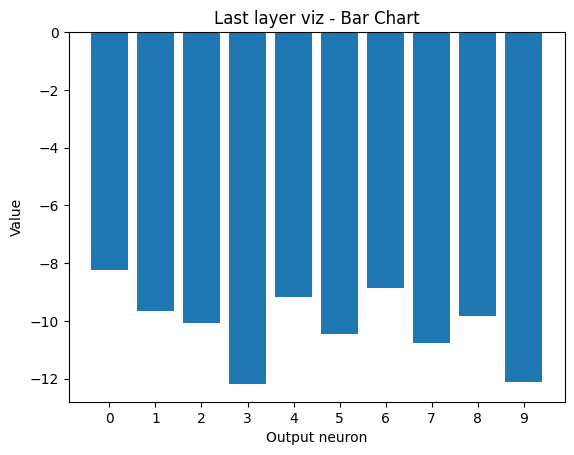

In [ ]:
import matplotlib.pyplot as plt

x_indices = range(10)

plt.bar(x_indices, new_output)
plt.xlabel('Output neuron')
plt.ylabel('Value')
plt.title('Last layer viz - Bar Chart')

# Customize x-axis tick labels
plt.xticks(x_indices, x_indices)

plt.show()


In [ ]:
import pickle
import os

root = os.getcwd()

with open(os.path.join(root  ,'new_trained_weights.pkl'), 'wb') as file:
    pickle.dump(weights, file)

In [ ]:
with open(os.path.join(root  ,'trained_weights.pkl'), 'rb') as file:
    var = pickle.load(file)